# Danish krone (DKK) exchange and cross rates analysis

Analysis for last 5 years, from 2019-01-01 to 2023-02-29

## Importing libraries

In [1]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

## Defining processing and visualizing functions

In [2]:
def clean_ecb_exchange_rates(ecb_rates_df: pd.DataFrame) -> pd.DataFrame:
    ecb_rates_df.columns = ["date", "time_period", "ecb_exchange_rate"]
    ecb_rates_df["date"] = pd.to_datetime(ecb_rates_df["date"])
    ecb_rates_df = ecb_rates_df.loc[
        ecb_rates_df["date"] >= datetime(2019,1,1),
        ["date", "ecb_exchange_rate"]
    ]

    return ecb_rates_df

In [3]:
def clean_dnb_exchange_rates(dnb_rates_df: pd.DataFrame) -> pd.DataFrame:
    dnb_rates_df.columns = ["date", "dnb_exchange_rate"]
    dnb_rates_df["date"] = pd.to_datetime(dnb_rates_df["date"], format="%YM%mD%d")
    dnb_rates_df = dnb_rates_df.loc[
        dnb_rates_df["date"] >= datetime(2019,1,1),
        ["date", "dnb_exchange_rate"]
    ]
    dnb_rates_df["dnb_exchange_rate"] = pd.to_numeric(dnb_rates_df["dnb_exchange_rate"], errors="coerce")
    dnb_rates_df["dnb_exchange_rate"] = dnb_rates_df["dnb_exchange_rate"] / 100
    dnb_rates_df.dropna(subset=["dnb_exchange_rate"], inplace=True)
    dnb_rates_df["prev_day_exchange_rate"] = dnb_rates_df["dnb_exchange_rate"].shift(1)
    dnb_rates_df["exchange_rate_daily_diff"] = dnb_rates_df["dnb_exchange_rate"] - dnb_rates_df["prev_day_exchange_rate"]

    return dnb_rates_df

In [4]:
def calculate_cross_rate(eur_dkk_df: pd.DataFrame, cross_currency_df: pd.DataFrame) -> pd.DataFrame:
    cross_rate_df = pd.merge(
        eur_dkk_df, cross_currency_df, how="inner", on="date", suffixes=("_eur_dkk", "_cross")
    )
    cross_rate_df["cross_rate"] = cross_rate_df["ecb_exchange_rate_eur_dkk"] / cross_rate_df["ecb_exchange_rate_cross"]
    cross_rate_df = cross_rate_df.loc[:, ["date", "cross_rate"]]

    return cross_rate_df

In [5]:
def plot_rates(exchange_rates_df: pd.DataFrame, cross_rates_df: pd.DataFrame, currency_pair: str) -> None:
    fig, ax = plt.subplots(2, 1, layout='constrained')
    fig.set_figheight(14)
    fig.set_figwidth(20)
    ax[0].plot(exchange_rates_df["date"], exchange_rates_df["dnb_exchange_rate"], label="exchange rate", alpha=0.5, color="#0834c4")
    ax[0].plot(cross_rates_df["date"], cross_rates_df["cross_rate"], label="cross rate", alpha=0.5, color="#ff0d00")
    ax[0].set_title(f"Exchange Rate vs Cross Rate for {currency_pair}")
    ax[0].legend()
    
    rates_diff = pd.merge(exchange_rates_df, cross_rates_df, how="inner", on="date")
    rates_diff["rate_diff"] = rates_diff["dnb_exchange_rate"] - rates_diff["cross_rate"]
    ax[1].plot(rates_diff["date"], rates_diff["rate_diff"], label="rate difference")
    ax[1].set_title(f"Difference of Exchange Rate vs Cross Rate for {currency_pair}")
    ax[1].legend()
    
    plt.show()

## Loading datasets from European Central Bank and Denmark National Bank

In [6]:
ecb_eur_dkk = pd.read_csv("data/ecb/EURDKK.csv")
ecb_gbp_eur = pd.read_csv("data/ecb/EURGBP.csv")
ecb_eur_usd = pd.read_csv("data/ecb/EURUSD.csv")
ecb_eur_jpy = pd.read_csv("data/ecb/EURJPY.csv")

In [7]:
dnb_eur_dkk = pd.read_csv("data/denmark_national_bank/EURO.csv", header=2).reset_index(drop=True)
dnb_gbp_dkk = pd.read_csv("data/denmark_national_bank/GBP.csv", header=2).reset_index(drop=True)
dnb_usd_dkk = pd.read_csv("data/denmark_national_bank/USD.csv", header=2).reset_index(drop=True)
dnb_jpy_dkk = pd.read_csv("data/denmark_national_bank/JPY.csv", header=2).reset_index(drop=True)

## Cleaning datasets
Data types conversion
Date filtering
Renaming columns
Adjusting exchange price

In [8]:
ecb_eur_dkk = clean_ecb_exchange_rates(ecb_eur_dkk)
ecb_gbp_eur = clean_ecb_exchange_rates(ecb_gbp_eur)
ecb_eur_usd = clean_ecb_exchange_rates(ecb_eur_usd)
ecb_eur_jpy = clean_ecb_exchange_rates(ecb_eur_jpy)

In [9]:
dnb_eur_dkk = clean_dnb_exchange_rates(dnb_eur_dkk)
dnb_gbp_dkk = clean_dnb_exchange_rates(dnb_gbp_dkk)
dnb_usd_dkk = clean_dnb_exchange_rates(dnb_usd_dkk)
dnb_jpy_dkk = clean_dnb_exchange_rates(dnb_jpy_dkk)

## Highest appreciation and depreciation
*In case of multiple dates having the same appreciation/depreciation, the latest one is picked.

In [10]:
exchange_rate_extremes = pd.DataFrame(
    [
        ["EUR", dnb_eur_dkk.nsmallest(1, "dnb_exchange_rate").date.max(), dnb_eur_dkk.nlargest(1, "dnb_exchange_rate").date.max()],
        ["GBP", dnb_gbp_dkk.nsmallest(1, "dnb_exchange_rate").date.max(), dnb_gbp_dkk.nlargest(1, "dnb_exchange_rate").date.max()],
        ["USD", dnb_usd_dkk.nsmallest(1, "dnb_exchange_rate").date.max(), dnb_usd_dkk.nlargest(1, "dnb_exchange_rate").date.max()],
        ["JPY", dnb_jpy_dkk.nsmallest(1, "dnb_exchange_rate").date.max(), dnb_jpy_dkk.nlargest(1, "dnb_exchange_rate").date.max()]
    ],
    columns=["currency", "highest_depreciation_date", "highest_appreciation_date"]
)

In [11]:
exchange_rate_extremes.head()

,currency,highest_depreciation_date,highest_appreciation_date
0,EUR,2021-09-20,2019-11-21
1,GBP,2020-03-23,2022-03-04
2,USD,2021-01-06,2022-09-28
3,JPY,2023-11-16,2020-05-06


## Highest daily appreciation and depreciation
*In case of multiple dates having the same appreciation/depreciation, the latest one is picked.

In [12]:
daily_change_extremes = pd.DataFrame(
    [
        ["EUR", dnb_eur_dkk.nsmallest(1, "exchange_rate_daily_diff").date.max(), dnb_eur_dkk.nlargest(1, "exchange_rate_daily_diff").date.max()],
        ["GBP", dnb_gbp_dkk.nsmallest(1, "exchange_rate_daily_diff").date.max(), dnb_gbp_dkk.nlargest(1, "exchange_rate_daily_diff").date.max()],
        ["USD", dnb_usd_dkk.nsmallest(1, "exchange_rate_daily_diff").date.max(), dnb_usd_dkk.nlargest(1, "exchange_rate_daily_diff").date.max()],
        ["JPY", dnb_jpy_dkk.nsmallest(1, "exchange_rate_daily_diff").date.max(), dnb_jpy_dkk.nlargest(1, "exchange_rate_daily_diff").date.max()]
    ],
    columns=["currency", "highest_fall_date", "highest_growth_date"]
)

In [13]:
daily_change_extremes.head()

,currency,highest_fall_date,highest_growth_date
0,EUR,2020-03-27,2020-03-30
1,GBP,2020-03-02,2019-10-11
2,USD,2022-11-11,2022-09-14
3,JPY,2020-03-13,2023-03-15


## Exchange Rate vs Cross Rate analysis

### Calculating cross rates

In [14]:
cross_rate_usd_dkk = calculate_cross_rate(ecb_eur_dkk, ecb_eur_usd)
cross_rate_gbp_dkk = calculate_cross_rate(ecb_eur_dkk, ecb_gbp_eur)
cross_rate_jpy_dkk = calculate_cross_rate(ecb_eur_dkk, ecb_eur_jpy)

### Visualization

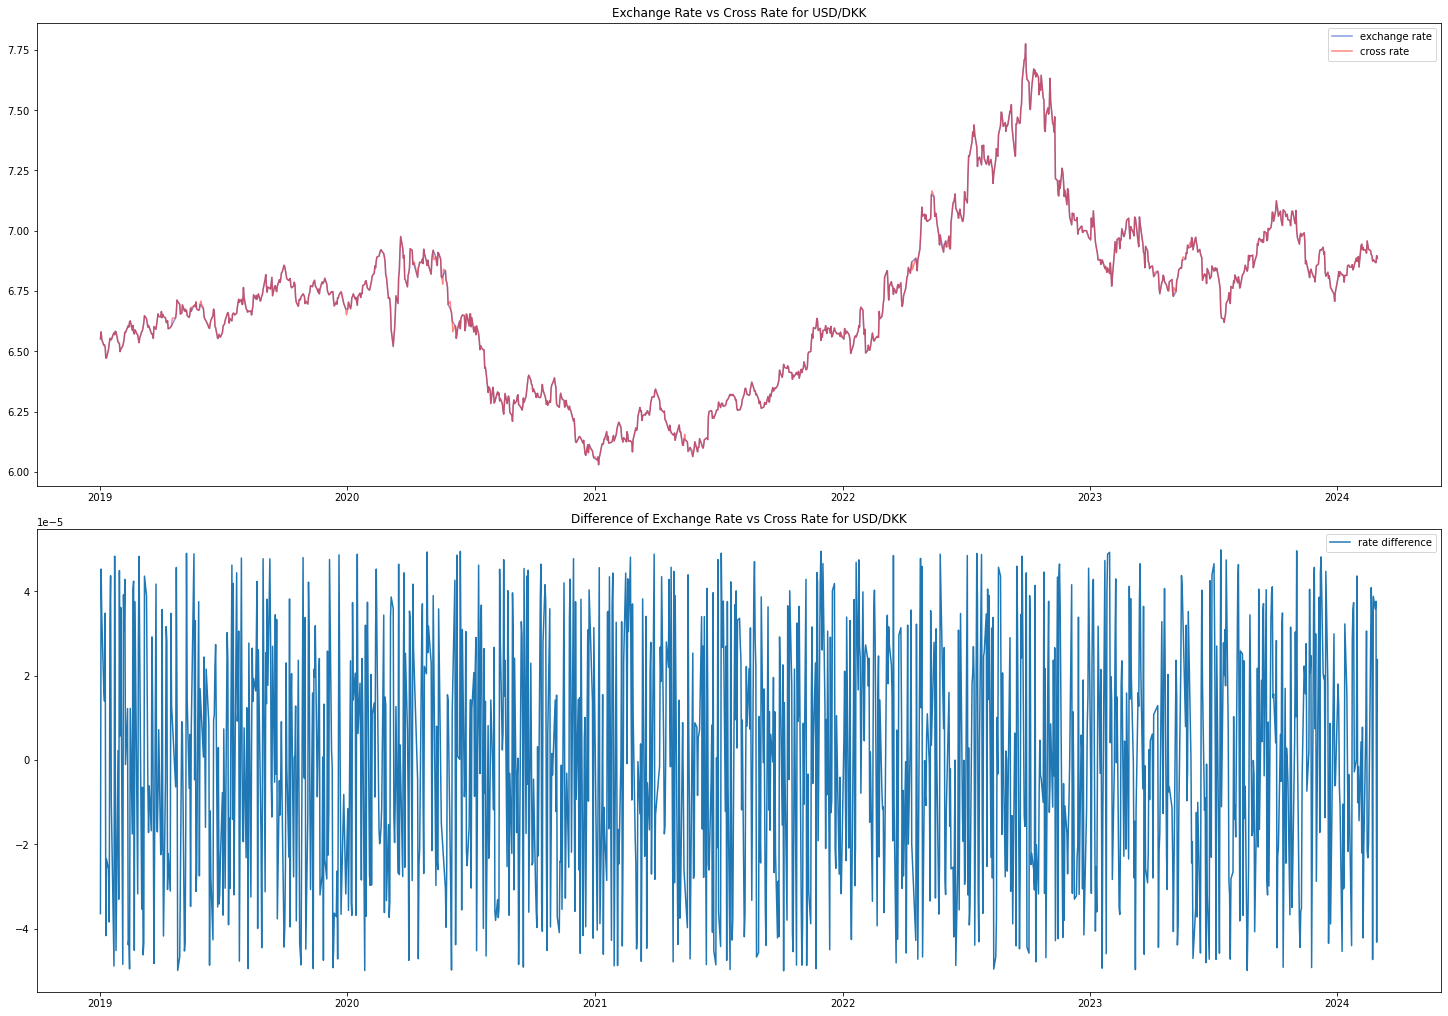

In [15]:
plot_rates(dnb_usd_dkk, cross_rate_usd_dkk, "USD/DKK")

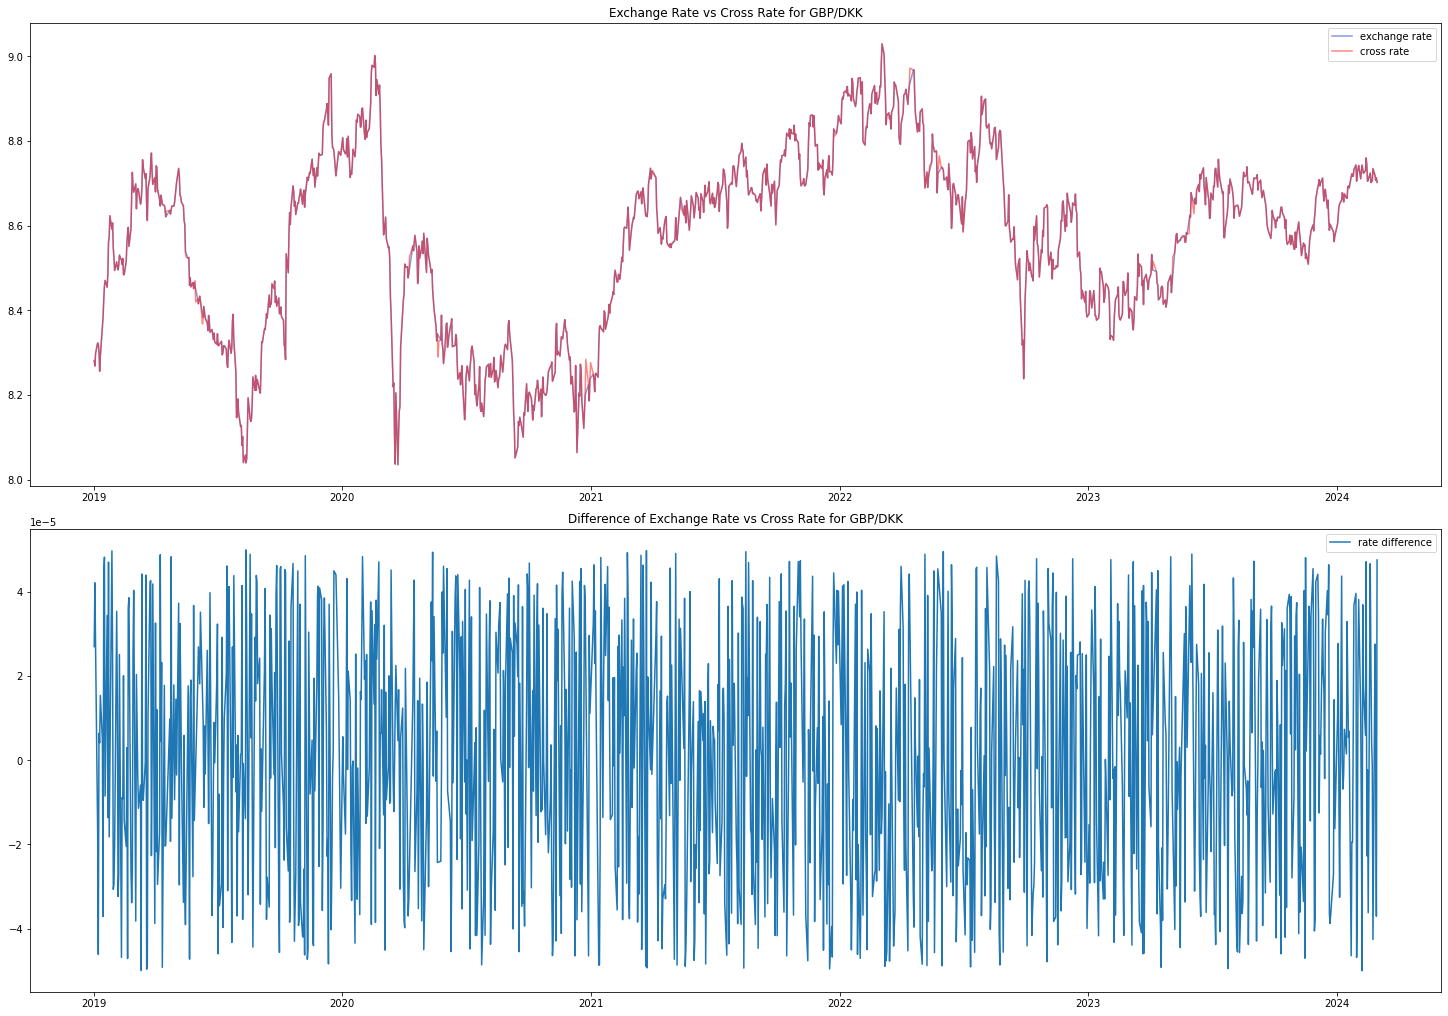

In [16]:
plot_rates(dnb_gbp_dkk, cross_rate_gbp_dkk, "GBP/DKK")

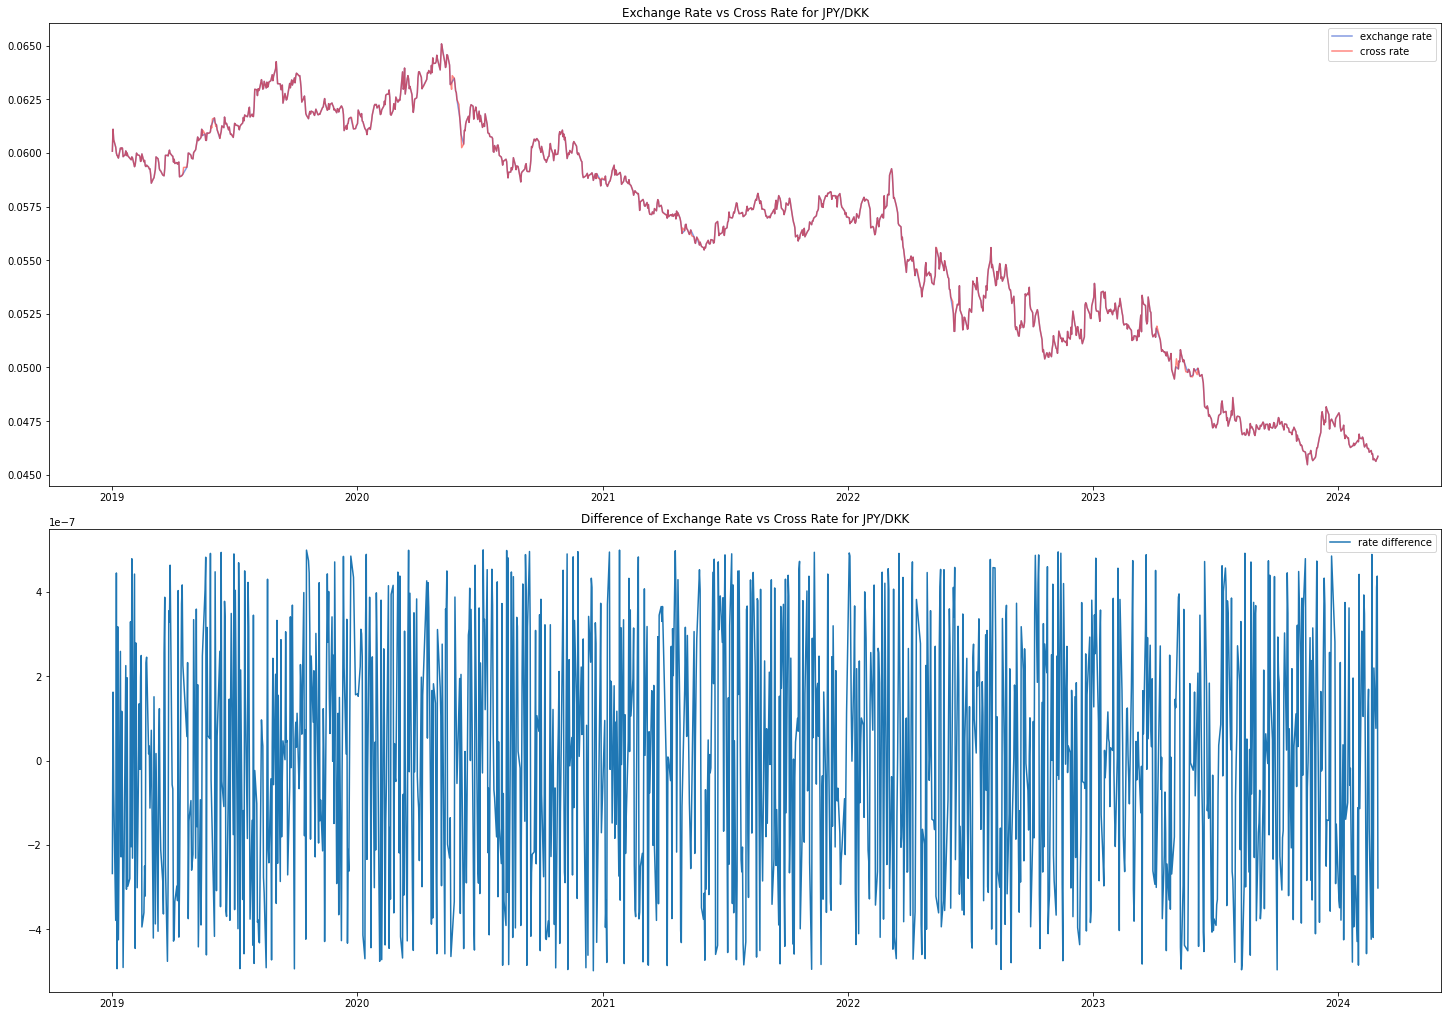

In [17]:
plot_rates(dnb_jpy_dkk, cross_rate_jpy_dkk, "JPY/DKK")